# **Optimizing Agentic Feature Extractor Configuration for Cost and Quality Efficiency**

## **Introduction**

In this notebook, we aim to identify the optimal configuration for the `AgenticFeatureExtractor` by experimenting with different values of `max_missing_feature_attempts` and `max_low_confidence_attempts`. Our goal is to balance the cost and time of feature extraction with the quality of the extracted data.

We will:

- Run the agent on a sample dataset with various configurations.
- Collect metrics such as cost, time taken, and data quality.
- Visualize and analyze the results to determine the optimal configuration.

---

## **Setup and Imports**

First, we import all necessary libraries and set up configurations for logging, display options, and visual styles.


In [1]:
import os
import sys
import logging
import asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell

# Set up project root and import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from config import Config
from prompts import PromptManager
from services import OpenAIService, TavilyService, WeaviateService
from feature_extraction import AgenticFeatureExtractor, ConfigSchema

# Load configuration and initialize services
config = Config()
openai_service = OpenAIService(config.OPENAI_API_KEY, config)
tavily_service = TavilyService(config.TAVILY_API_KEY)
weaviate_service = WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL)
await weaviate_service.initialize_weaviate(True)

services = {
    "openai_service": openai_service,
    "tavily_service": tavily_service,
    "weaviate_service": weaviate_service
}
prompt_manager = PromptManager()

# Set up display options and styles
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

# Configure logging
logging.basicConfig(level=logging.ERROR, force=True)

---

## **Data Loading and Preparation**

We load a sample dataset of 10 entries from our product data and display an overview.


In [2]:
old_products = pd.read_csv("../data/filtered_products.csv")
raw_data = old_products[["id", "raw_data"]].sample(n=5, random_state=42).reset_index(drop=True)

# Display dataset information and head
raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5 non-null      object
 1   raw_data  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              


---


## **Define Experiment Configurations**

We define a list of configurations to test different combinations of `max_missing_feature_attempts` and `max_low_confidence_attempts`.


In [3]:
configurations = [
    {'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0},
    # {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0},
    # {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 1},
    # {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 0},
    # {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 1},
    {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 2},
    # {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 0},
    # {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 1},
    # {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 2},
    # {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 3},
]


---

## **Experiment Execution**

We run the agent on each entry in the sample dataset for each configuration, collecting results and usage statistics.


In [4]:
logging.basicConfig(level=logging.INFO, force=True)

In [4]:
async def check_weaviate_connection():
    try:
        await weaviate_service.wi.client.connect()
        is_ready = await weaviate_service.wi.client.is_ready()
        if not is_ready:
            raise Exception("Weaviate is not ready")
        print("Weaviate connection successful")
    except Exception as e:
        print(f"Error connecting to Weaviate: {e}")
        raise


# Add this before running experiments
await check_weaviate_connection()

Weaviate connection successful


In [5]:
async def run_agentic_extractor(product_id, raw_data_entry, cfg):
    try:
        print(f"Running agent on product {product_id}")

        weaviate_service = WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL)

        services = {
            "openai_service": OpenAIService(config.OPENAI_API_KEY, config),
            "tavily_service": TavilyService(config.TAVILY_API_KEY),
            "weaviate_service": weaviate_service,
        }

        # Proceed as before
        agent_config = ConfigSchema(
            model_name="gpt-4o",
            max_missing_feature_attempts=cfg["max_missing_feature_attempts"],
            max_low_confidence_attempts=cfg["max_low_confidence_attempts"],
            confidence_threshold=0.7,
        )
        prompt_manager = PromptManager()
        agent = AgenticFeatureExtractor(services, prompt_manager, config=agent_config)

        result = await agent.extract_data(raw_data_entry, product_id)
        extracted_data = result["extracted_data"]
        usage_data = result["usage"]

        # Close the Weaviate client
        await weaviate_service.wi.client.close()

        return extracted_data, usage_data
    except Exception as e:
        print(f"Error processing product {product_id}: {e}")
        return {}, {}

In [7]:
all_results = []

for cfg in configurations:
    await weaviate_service.initialize_weaviate(True)
    cfg_results = []

    # Split data into batches of five
    batch_size = 5
    batches = [raw_data[i : i + batch_size] for i in range(0, len(raw_data), batch_size)]

    for batch_num, batch in enumerate(batches):
        print(f"Processing batch {batch_num+1}/{len(batches)} with config {cfg}")

        tasks = [run_agentic_extractor(row["id"], row["raw_data"], cfg) for idx, row in batch.iterrows()]
        results = await asyncio.gather(*tasks)

        for idx, result in enumerate(results):
            cfg_results.append({
                "id": batch.loc[idx, "id"],
                "config": cfg,
                "extracted_data": result[0],
                "usage_data": result[1],
                "raw_data_length": len(batch.loc[idx, "raw_data"]),
            })

    # Store the results for this configuration
    all_results.extend(cfg_results)

Processing batch 1/1 with config {'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2
Processing batch 1/1 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 2}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


ERROR:services.tavily_service:Error in Tavily search: Your request will exceed the API usage limit. Please upgrade your plan or contact support@tavily.com
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Your request will exceed the API usage limit. Please upgrade your plan or contact support@tavily.com
ERROR:services.tavily_service:Error in Tavily search: Your request will exceed the API usage limit. Please upgrade your plan or contact support@tavily.com
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Your request will exceed the API usage limit. Please upgrade your plan or contact support@tavily.com
ERROR:services.tavily_service:Error in Tavily search: Your request will exceed the API usage limit. Please upgrade your plan or contact support@tavily.com
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Your request will exceed the API usage limit. Please u

In [9]:
# Convert all_results to DataFrame
results_df = pd.DataFrame(all_results)

In [10]:
results_df.info()
results_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               10 non-null     object
 1   config           10 non-null     object
 2   extracted_data   10 non-null     object
 3   usage_data       10 non-null     object
 4   raw_data_length  10 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 528.0+ bytes


,id,config,extracted_data,usage_data,raw_data_length
0,EmNANO-i2300-E3825,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}","{'name': 'EMNANOIE', 'manufacturer': 'ARBOR TECHNOLOGY', 'form_factor': 'COM Express Mini', 'evaluation_or_commercialization': True, 'processor_architecture': 'x86', 'processor_core_count': 'Not Available', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'Not Available', 'memory': '4GB DDR3L SDRAM', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4 x USB ports', '1 x USB port', '2 x Serial ports', '2 x PCIe x1 Gen2 lanes', '2 x Serial ATA ports'], 'wireless': 'Not Available', 'operating_system_bsp': 'Not Available', 'operating_temperature_max': 'Not Available', 'operating_temperature_min': 'Not Available', 'certifications': 'Not Available', 'price': 'Not Available', 'stock_availability': 'Not Available', 'lead_time': 'Not Available', 'short_summary': 'Intel Atom E series processor COM Express Mini Type CPU Module with soldered onboard Intel Atom E series SoC processor.', 'full_summary': 'The EMNANOIE is a COM Express Mini Type CPU module featuring an Intel Atom E series processor. It includes soldered onboard Intel Atom E series SoC processor, integrated Gigabit Ethernet, multiple USB ports, and support for dual independent displays.', 'full_product_description': 'The EMNANOIE is a COM Express Mini Type CPU module designed for evaluation purposes. It features an Intel Atom E series processor with soldered onboard SoC, integrated Gigabit Ethernet, multiple USB ports, serial ports, and support for dual independent displays. It includes 4GB DDR3L SDRAM and supports various interfaces such as PCIe, SATA, and LVDS.', 'target_applications': 'Not Available'}","{'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 4.694906234741211}], 'extract_features': [{'input_tokens': 1133, 'output_tokens': 783, 'time_taken': 11.397341966629028}]}",2003
1,conga-B7XDslashP-D1508,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}","{'name': 'CONGABXD', 'manufacturer': 'CONGATEC', 'form_factor': 'COM EXPRESS BASIC 125 X 95 MM', 'evaluation_or_commercialization': False, 'processor_architecture': 'X86', 'processor_core_count': 'VARIES (UP TO 16 CORES)', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'VARIES (UP TO 65W)', 'memory': 'DUAL CHANNEL DDR4 2400 MT/S, UP TO 64GB', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4x USB 3.0', '8x USB 2.0', '4x SATA III', '1x LPC', '1x SPI', '1x I2C', '2x UART', '1x SMBus', '2x GbE KR'], 'wireless': 'Not Available', 'operating_system_bsp': ['WINDOWS 10', 'WINDOWS SERVER 2016', 'WINDOWS SERVER 2019', 'RHEL', 'SUSE', 'FEDORA', 'UBUNTU', 'CENTOS', 'FREEBSD', 'VMWARE', 'HYPERV', 'XEN', 'ESXI'], 'operating_temperature_max': '85°C', 'operating_temperature_min': '-40°C', 'certifications': 'Not Available', 'price': 'Not Available', 'stock_availability': 'Not Available', 'lead_time': 'Not Available', 'short_summary': 'COM Express Type 7 module with Intel Xeon D processors, up to 16 cores, dual channel DDR4 memory, and extensive I/O interfaces.', 'full_summary': 'The conga-BXD is a COM Express Type 7 module featuring Intel Xeon D processors with up to 16 cores, dual channel DDR4 memory support up to 64GB, and a wide range of I/O interfaces including USB, SATA, PCIe, and Ethernet. It is designed for industrial and server-class applications with support for various operating systems and extended temperature ranges.', 'full_product_description': 'The conga-BXD COM Express Type 7 module is equipped with Intel Xeon D processors, offering up to 16 cores and 24MB cache. It supports dual channel DDR4 2400 MT/s memory up to 64GB with ECC option. The module includes extensive I/O interfaces such as 4x USB 3.0, 8x USB 2.0, 4x SATA III, 1x LPC, 1x SPI, 1x I2C, 2x UART, 1x SMBus, and 2x GbE KR. It is suitable for industrial and server-class applications, supporting a

In [25]:
# save results_df to file
results_df.to_csv("../data/results_df.csv", index=False)

In [22]:
# Expand extracted_data into separate columns
extracted_df = pd.json_normalize(results_df["extracted_data"])
# Concatenate with the original DataFrame
full_df = pd.concat([results_df.drop(["extracted_data"], axis=1), extracted_df], axis=1)
full_df = full_df.mask(full_df.isin(["Not Available", None]), np.nan).infer_objects(copy=False)


def config_to_str(cfg):
    return f"miss:{cfg['max_missing_feature_attempts']}_low:{cfg['max_low_confidence_attempts']}"


# Apply the function to create a string representation of the configuration
results_df["config_str"] = results_df["config"].apply(config_to_str)

# drop config column
results_df = results_df.drop(columns=["config"])

full_df.info()
full_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               10 non-null     object 
 1   usage_data                       10 non-null     object 
 2   raw_data_length                  10 non-null     int64  
 3   config_str                       10 non-null     object 
 4   name                             10 non-null     object 
 5   manufacturer                     10 non-null     object 
 6   form_factor                      8 non-null      object 
 7   evaluation_or_commercialization  10 non-null     object 
 8   processor_architecture           8 non-null      object 
 9   processor_core_count             4 non-null      object 
 10  processor_manufacturer           10 non-null     object 
 11  processor_tdp                    2 non-null      object 
 12  memory                   

,id,usage_data,raw_data_length,config_str,name,manufacturer,form_factor,evaluation_or_commercialization,processor_architecture,processor_core_count,processor_manufacturer,processor_tdp,memory,onboard_storage,input_voltage,io_count,wireless,operating_system_bsp,operating_temperature_max,operating_temperature_min,certifications,price,stock_availability,lead_time,short_summary,full_summary,full_product_description,target_applications
0,EmNANO-i2300-E3825,"{'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 4.694906234741211}], 'extract_features': [{'input_tokens': 1133, 'output_tokens': 783, 'time_taken': 11.397341966629028}]}",2003,miss:0_low:0,EMNANOIE,ARBOR TECHNOLOGY,COM Express Mini,True,x86,NaN,INTEL,NaN,4GB DDR3L SDRAM,NaN,NaN,"[4 x USB ports, 1 x USB port, 2 x Serial ports, 2 x PCIe x1 Gen2 lanes, 2 x Serial ATA ports]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intel Atom E series processor COM Express Mini Type CPU Module with soldered onboard Intel Atom E series SoC processor.,"The EMNANOIE is a COM Express Mini Type CPU module featuring an Intel Atom E series processor. It includes soldered onboard Intel Atom E series SoC processor, integrated Gigabit Ethernet, multiple USB ports, and support for dual independent displays.","The EMNANOIE is a COM Express Mini Type CPU module designed for evaluation purposes. It features an Intel Atom E series processor with soldered onboard SoC, integrated Gigabit Ethernet, multiple USB ports, serial ports, and support for dual independent displays. It includes 4GB DDR3L SDRAM and supports various interfaces such as PCIe, SATA, and LVDS.",NaN
1,conga-B7XDslashP-D1508,"{'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 5.280362129211426}], 'extract_features': [{'input_tokens': 2695, 'output_tokens': 1089, 'time_taken': 14.969635009765625}]}",8169,miss:0_low:0,CONGABXD,CONGATEC,COM EXPRESS BASIC 125 X 95 MM,False,X86,VARIES (UP TO 16 CORES),INTEL,VARIES (UP TO 65W),"DUAL CHANNEL DDR4 2400 MT/S, UP TO 64GB",NaN,NaN,"[4x USB 3.0, 8x USB 2.0, 4x SATA III, 1x LPC, 1x SPI, 1x I2C, 2x UART, 1x SMBus, 2x GbE KR]",NaN,"[WINDOWS 10, WINDOWS SERVER 2016, WINDOWS SERVER 2019, RHEL, SUSE, FEDORA, UBUNTU, CENTOS, FREEBSD, VMWARE, HYPERV, XEN, ESXI]",85°C,-40°C,NaN,NaN,NaN,NaN,"COM Express Type 7 module with Intel Xeon D processors, up to 16 cores, dual channel DDR4 memory, and extensive I/O interfaces.","The conga-BXD is a COM Express Type 7 module featuring Intel Xeon D processors with up to 16 cores, dual channel DDR4 memory support up to 64GB, and a wide range of I/O interfaces including USB, SATA, PCIe, and Ethernet. It is designed for industrial and server-class applications with support for various operating systems and extended temperature ranges.","The conga-BXD COM Express Type 7 module is equipped with Intel Xeon D processors, offering up to 16 cores and 24MB cache. It supports dual channel DDR4 2400 MT/s memory up to 64GB with ECC option. The module includes extensive I/O interfaces such as 4x USB 3.0, 8x USB 2.0, 4x SATA III, 1x LPC, 1x SPI, 1x I2C, 2x UART, 1x SMBus, and 2x GbE KR. It is suitable for industrial and server-class applications, supporting a wide range of operating systems including Windows, Linux, and virtualization platforms. The module operates in temperatures ranging from -40°C to 85°C, making it ideal for harsh environments.","[INDUSTRIAL AUTOMATION, SERVER-CLASS APPLICATIONS, NETWORKING, TELECOMMUNICATIONS, EDGE COMPUTING]"


In [29]:
extracted_df = full_df[
    [
        "id",
        "name",
        "manufacturer",
        "form_factor",
        "evaluation_or_commercialization",
        "processor_architecture",
        "processor_core_count",
        "processor_manufacturer",
        "processor_tdp",
        "memory",
        "onboard_storage",
        "input_voltage",
        "io_count",
        "wireless",
        "operating_system_bsp",
        "operating_temperature_max",
        "operating_temperature_min",
        "certifications",
        "price",
        "stock_availability",
        "lead_time",
    ]
].copy()

extracted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               10 non-null     object 
 1   name                             10 non-null     object 
 2   manufacturer                     10 non-null     object 
 3   form_factor                      8 non-null      object 
 4   evaluation_or_commercialization  10 non-null     object 
 5   processor_architecture           8 non-null      object 
 6   processor_core_count             4 non-null      object 
 7   processor_manufacturer           10 non-null     object 
 8   processor_tdp                    2 non-null      object 
 9   memory                           8 non-null      object 
 10  onboard_storage                  0 non-null      float64
 11  input_voltage                    6 non-null      object 
 12  io_count                 

In [23]:
# Function to flatten usage_data
def flatten_usage_data(row):
    usage_entries = []
    for step, entries in row["usage_data"].items():
        for entry in entries:
            entry.update({"step": step, "id": row["id"], "config": row["config_str"]})
            usage_entries.append(entry)
    return usage_entries


# Apply the function and create a DataFrame
usage_records = []
for idx, row in results_df.iterrows():
    usage_records.extend(flatten_usage_data(row))

usage_df = pd.DataFrame(usage_records)

usage_df.info()
usage_df.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   input_tokens   40 non-null     int64  
 1   output_tokens  40 non-null     int64  
 2   time_taken     40 non-null     float64
 3   step           40 non-null     object 
 4   id             40 non-null     object 
 5   config         40 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.0+ KB


,input_tokens,output_tokens,time_taken,step,id,config
0,0,0,4.69,store_and_chunk_data,EmNANO-i2300-E3825,miss:0_low:0
1,1133,783,11.40,extract_features,EmNANO-i2300-E3825,miss:0_low:0



---


In [30]:
missing_rates = extracted_df.isna().mean().sort_values(ascending=False)
print(missing_rates)

onboard_storage                   1.00
price                             1.00
stock_availability                1.00
lead_time                         1.00
processor_tdp                     0.80
wireless                          0.80
certifications                    0.60
processor_core_count              0.60
operating_system_bsp              0.60
operating_temperature_max         0.60
operating_temperature_min         0.60
input_voltage                     0.40
memory                            0.20
form_factor                       0.20
processor_architecture            0.20
evaluation_or_commercialization   0.00
manufacturer                      0.00
io_count                          0.00
name                              0.00
processor_manufacturer            0.00
id                                0.00
dtype: float64


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='None'>

Text(0.5, 1.0, 'Missing Rate per Feature')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Missing Rate')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'onboard_storage'),
  Text(1, 0, 'price'),
  Text(2, 0, 'stock_availability'),
  Text(3, 0, 'lead_time'),
  Text(4, 0, 'processor_tdp'),
  Text(5, 0, 'wireless'),
  Text(6, 0, 'certifications'),
  Text(7, 0, 'processor_core_count'),
  Text(8, 0, 'operating_system_bsp'),
  Text(9, 0, 'operating_temperature_max'),
  Text(10, 0, 'operating_temperature_min'),
  Text(11, 0, 'input_voltage'),
  Text(12, 0, 'memory'),
  Text(13, 0, 'form_factor'),
  Text(14, 0, 'processor_architecture'),
  Text(15, 0, 'evaluation_or_commercialization'),
  Text(16, 0, 'manufacturer'),
  Text(17, 0, 'io_count'),
  Text(18, 0, 'name'),
  Text(19, 0, 'processor_manufacturer'),
  Text(20, 0, 'id')])

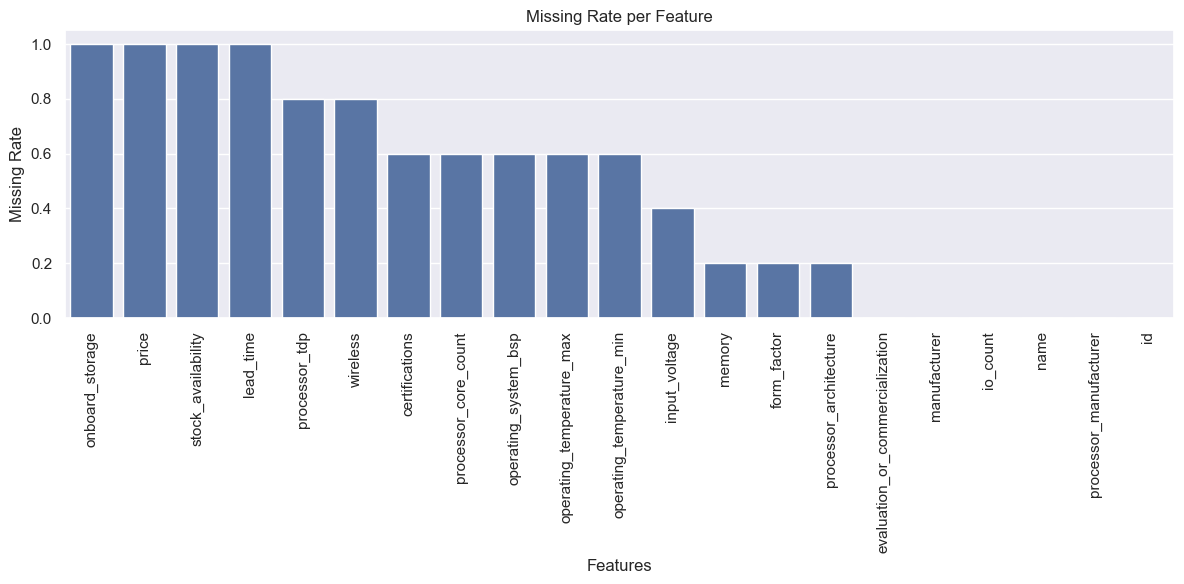

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_rates.index, y=missing_rates.values)
plt.title("Missing Rate per Feature")
plt.xlabel("Features")
plt.ylabel("Missing Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [32]:
step_stats = (
    usage_df.groupby(["config", "step"])
    .agg({"input_tokens": "sum", "output_tokens": "sum", "time_taken": "sum"})
    .reset_index()
)

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='step', ylabel='input_tokens'>

Text(0.5, 1.0, 'Input Tokens per Step')

Text(0.5, 0, 'Extraction Step')

Text(0, 0.5, 'Total Input Tokens')

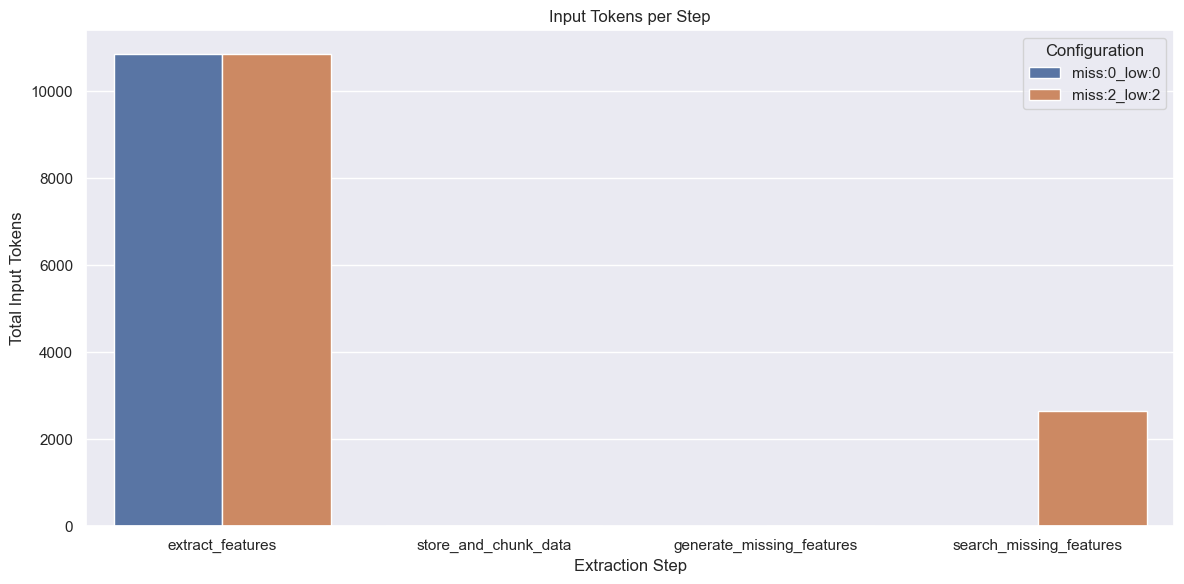

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data=step_stats, x="step", y="input_tokens", hue="config")
plt.title("Input Tokens per Step")
plt.xlabel("Extraction Step")
plt.ylabel("Total Input Tokens")
plt.legend(title="Configuration")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Missing Data Heatmap')

Text(0.5, 33.109374999999986, 'Features')

Text(117.24999999999999, 0.5, 'Products')

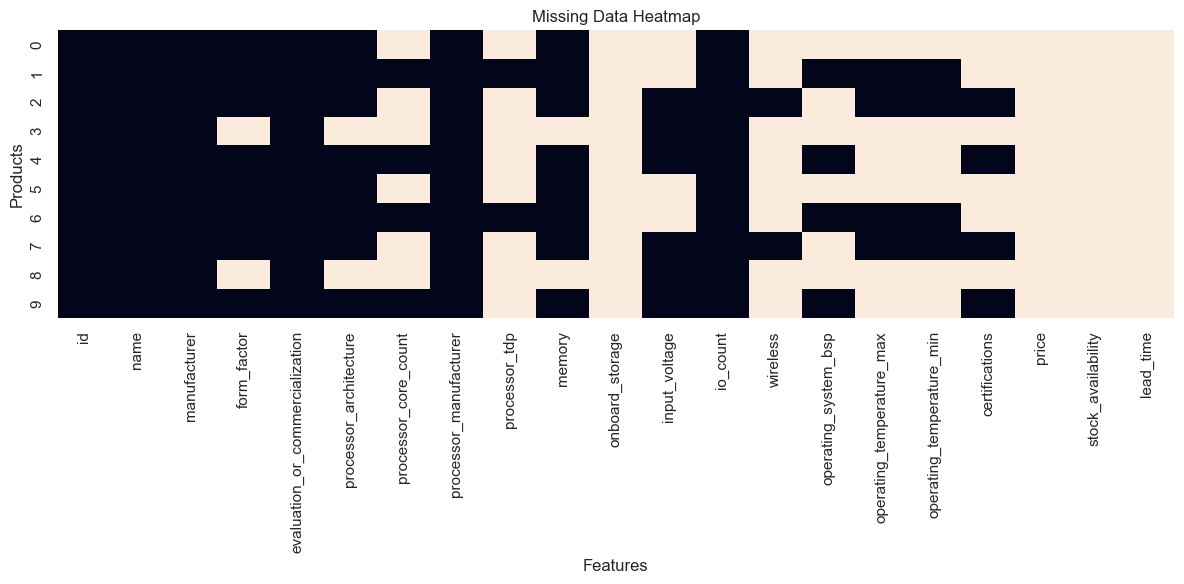

In [33]:
plt.figure(figsize=(12, 6))
sns.heatmap(extracted_df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.xlabel("Features")
plt.ylabel("Products")
plt.tight_layout()
plt.show()

In [27]:
feature_success = full_df.groupby("config_str").apply(lambda df: df.notna().mean()).transpose()
print(feature_success)

config_str                       miss:0_low:0  miss:2_low:2
id                                       1.00          1.00
usage_data                               1.00          1.00
raw_data_length                          1.00          1.00
config_str                               1.00          1.00
name                                     1.00          1.00
manufacturer                             1.00          1.00
form_factor                              0.80          0.80
evaluation_or_commercialization          1.00          1.00
processor_architecture                   0.80          0.80
processor_core_count                     0.40          0.40
processor_manufacturer                   1.00          1.00
processor_tdp                            0.20          0.20
memory                                   0.80          0.80
onboard_storage                          0.00          0.00
input_voltage                            0.60          0.60
io_count                                

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16625/1783276606.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_success = full_df.groupby("config_str").apply(lambda df: df.notna().mean()).transpose()


<Axes: >

Text(0.5, 1.0, 'Feature Extraction Success Rates by Configuration')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Success Rate')

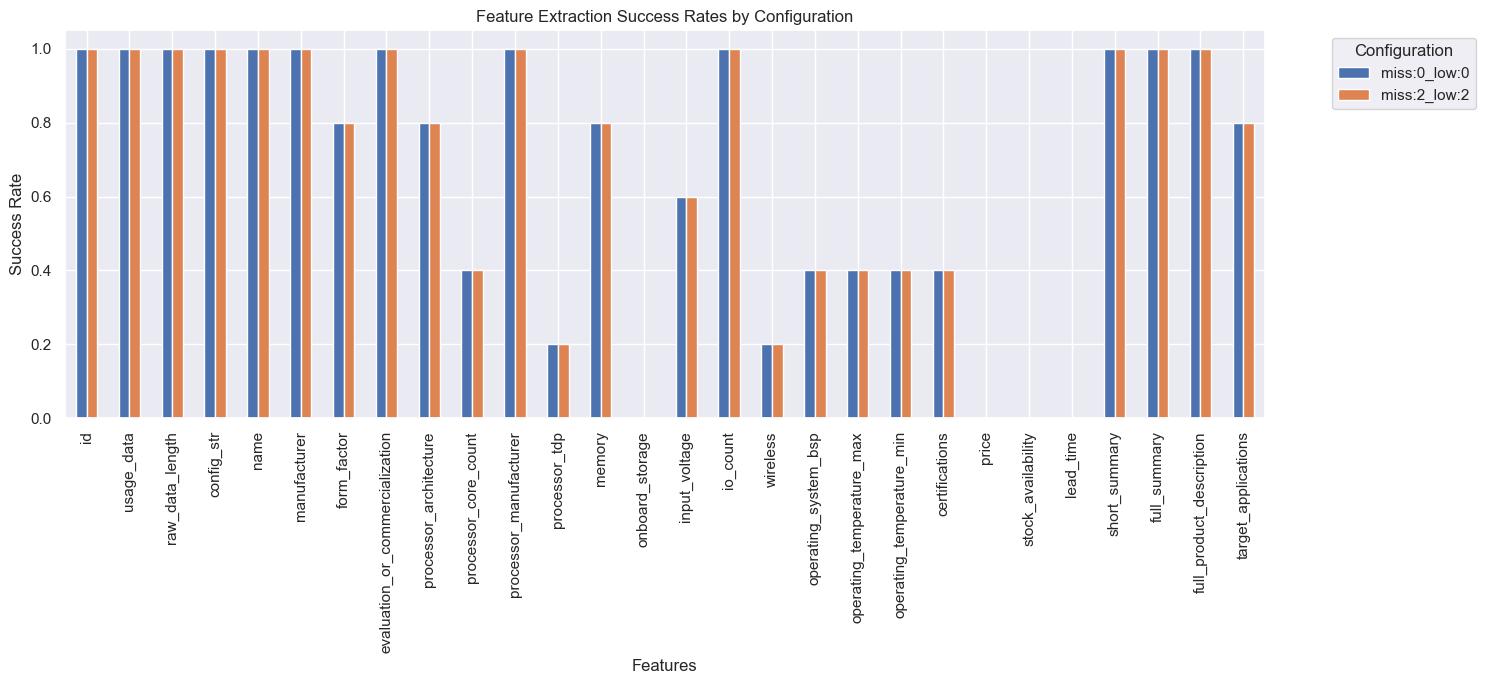

In [28]:
feature_success.plot(kind="bar", figsize=(15, 7))
plt.title("Feature Extraction Success Rates by Configuration")
plt.xlabel("Features")
plt.ylabel("Success Rate")
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## **Cost and Performance Calculation**

We calculate the cost and time taken for each run based on token usage and model pricing.


In [8]:
# Constants for pricing (gpt-4o)
INPUT_TOKEN_COST = 0.000005  # $5 per 1M input tokens
OUTPUT_TOKEN_COST = 0.00001  # $10 per 1M output tokens

# Function to calculate cost and time
def calculate_cost_and_time(usage_data):
    total_input_tokens = 0
    total_output_tokens = 0
    total_time = 0.0

    for usage_list in usage_data.values():
        for usage in usage_list:
            total_input_tokens += usage.get('input_tokens', 0)
            total_output_tokens += usage.get('output_tokens', 0)
            total_time += usage.get('time_taken', 0.0)

    input_cost = total_input_tokens * INPUT_TOKEN_COST
    output_cost = total_output_tokens * OUTPUT_TOKEN_COST
    total_cost = input_cost + output_cost

    return total_cost, total_time, total_input_tokens, total_output_tokens

In [9]:
def count_not_available_features(data):
    count = 0
    if isinstance(data, dict):
        for value in data.values():
            count += count_not_available_features(value)
    elif isinstance(data, list):
        for item in data:
            count += count_not_available_features(item)
    else:
        if data == "Not Available" or data is None:
            count += 1
    return count


def count_total_features(data):
    count = 0
    if isinstance(data, dict):
        for value in data.values():
            count += count_total_features(value)
    elif isinstance(data, list):
        for item in data:
            count += count_total_features(item)
    else:
        count += 1
    return count


---


## **Results Aggregation**

We aggregate the results across all configurations and compute averages and totals.


In [10]:
# Initialize lists to store aggregated metrics
aggregated_results = []

# Aggregate results per configuration
for cfg in configurations:
    cfg_data = results_df[results_df["config"] == cfg]

    total_cost = 0.0
    total_time = 0.0
    total_input_tokens = 0
    total_output_tokens = 0
    total_not_available = 0
    total_features_extracted = 0  # Initialize total features extracted

    for idx, row in cfg_data.iterrows():
        extracted_data = row["extracted_data"]
        usage_data = row["usage_data"]

        # Calculate cost and time
        cost, time_taken, input_tokens, output_tokens = calculate_cost_and_time(usage_data)
        total_cost += cost
        total_time += time_taken
        total_input_tokens += input_tokens
        total_output_tokens += output_tokens

        # Calculate data quality metrics
        not_available = count_not_available_features(extracted_data)
        total_not_available += not_available
        total_features = count_total_features(extracted_data)
        total_features_extracted += total_features

    avg_cost = total_cost / len(cfg_data)
    avg_time = total_time / len(cfg_data)
    avg_not_available = total_not_available / len(cfg_data)
    avg_features_extracted = total_features_extracted / len(cfg_data)

    aggregated_results.append(
        {
            "config": cfg,
            "total_cost": total_cost,
            "avg_cost": avg_cost,
            "total_time": total_time,
            "avg_time": avg_time,
            "total_input_tokens": total_input_tokens,
            "total_output_tokens": total_output_tokens,
            "avg_not_available_features": avg_not_available,
            "avg_features_extracted": avg_features_extracted,
        }
    )

# Convert aggregated_results to DataFrame
aggregated_df = pd.DataFrame(aggregated_results)

In [11]:

aggregated_df["config_str"] = aggregated_df["config"].apply(config_to_str)

In [12]:
aggregated_df

,config,total_cost,avg_cost,total_time,avg_time,total_input_tokens,total_output_tokens,avg_not_available_features,avg_features_extracted,config_str
0,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}",0.39,0.02,382.32,19.12,40746,18876,6.95,36.70,miss:0_low:0
1,"{'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0}",0.79,0.04,1987.66,99.38,113604,21860,6.30,36.05,miss:1_low:0
2,"{'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 1}",0.77,0.04,1712.67,85.63,110777,22108,6.15,37.45,miss:1_low:1
3,"{'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 2}",1.20,0.06,3017.84,150.89,190040,25251,5.95,37.00,miss:2_low:2
4,"{'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 3}",0.72,0.04,1314.27,65.71,104409,19857,6.35,34.80,miss:3_low:3


In [13]:
# save aggregated_df to file
aggregated_df.to_csv("../data/aggregated_df.csv", index=False)


In [22]:
aggregated_df.info

<bound method DataFrame.info of                                                                   config  total_cost  avg_cost  total_time  avg_time  total_input_tokens  total_output_tokens  avg_not_available_features  avg_features_extracted    config_str  cost_per_feature  time_per_feature  quality_score  cost_increase_ratio  time_increase_ratio  quality_improvement_ratio  efficiency_score
0  {'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}        0.39      0.02      382.32     19.12               40746                18876                        6.95                   36.70  miss:0_low:0              0.53              0.52           0.81                 1.00                 1.00                       1.00              1.00
1  {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0}        0.79      0.04     1987.66     99.38              113604                21860                        6.30                   36.05  miss:1_low:0              1.09   


---


## **Data Visualization**

### **Cost Comparison**

We create a bar chart to compare the total cost per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='total_cost'>

Text(0.5, 1.0, 'Total Cost per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Total Cost ($)')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:2'),
  Text(4, 0, 'miss:3_low:3')])

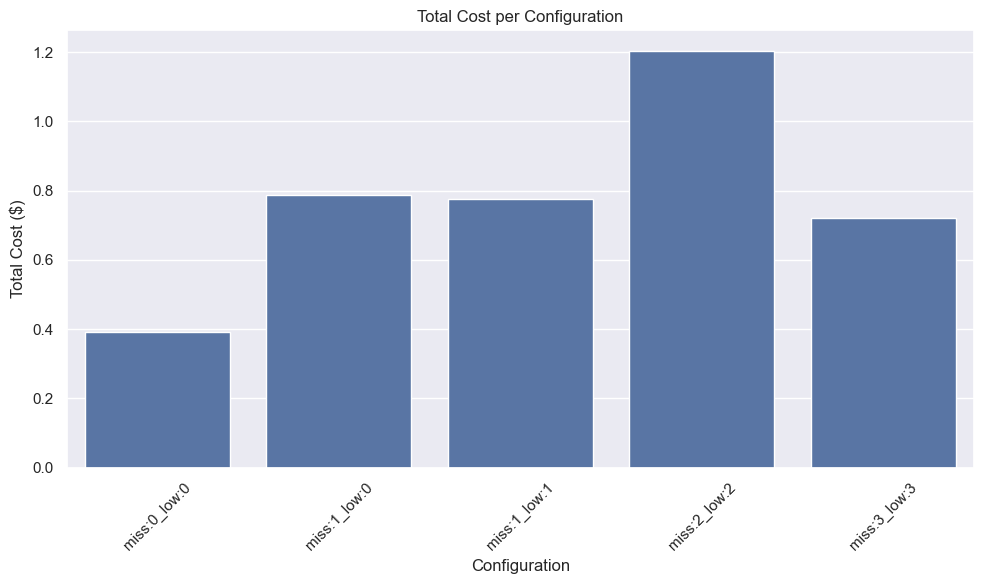

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="total_cost")
plt.title('Total Cost per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Total Cost ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Time Analysis**

We create a line plot to show the average time taken per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_time'>

Text(0.5, 1.0, 'Average Time Taken per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Time (s)')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:2'),
  Text(4, 0, 'miss:3_low:3')])

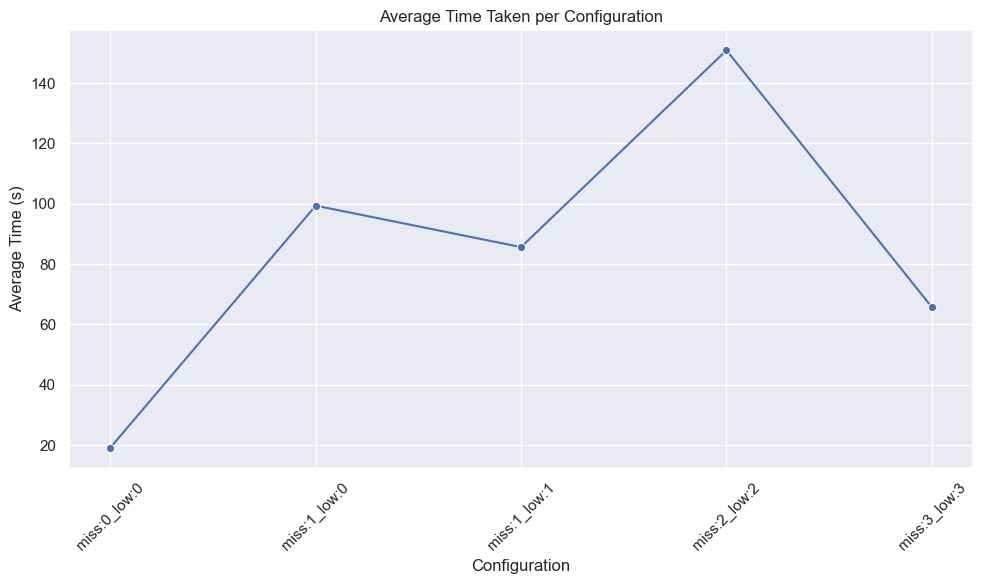

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=aggregated_df, x="config_str", y="avg_time", marker="o")
plt.title('Average Time Taken per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Average Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Feature Availability**

We create a bar chart to show the average number of "Not Available" features per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_not_available_features'>

Text(0.5, 1.0, 'Average "Not Available" Features per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Number of "Not Available" Features')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:2'),
  Text(4, 0, 'miss:3_low:3')])

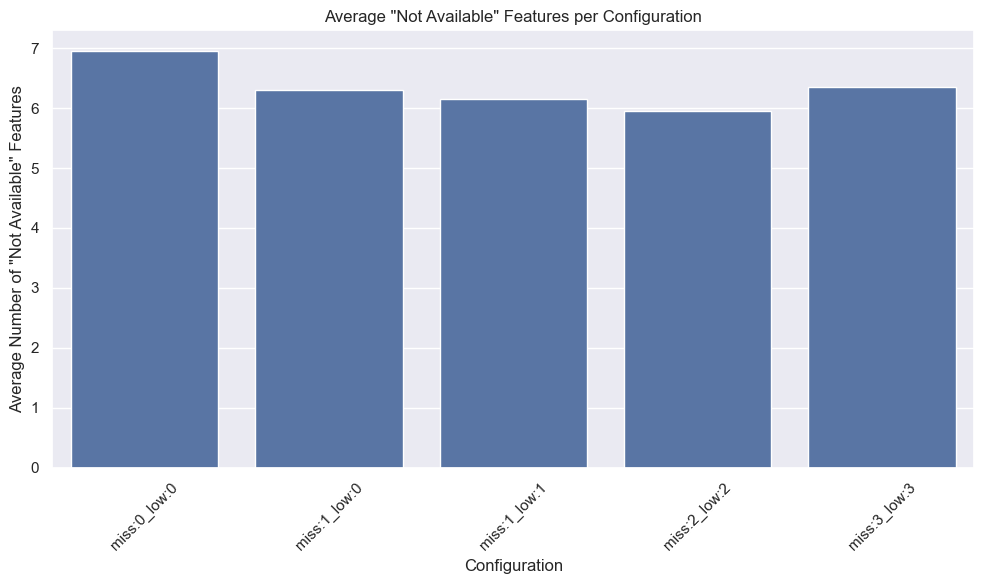

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="avg_not_available_features")
plt.title('Average "Not Available" Features per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Average Number of "Not Available" Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Trade-off Visualization**

We create a scatter plot to visualize the trade-off between cost and data quality.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_not_available_features'>

Text(0.5, 1.0, 'Cost vs. Data Quality Trade-off')

Text(0.5, 0, 'Total Cost ($)')

Text(0, 0.5, 'Average "Not Available" Features')

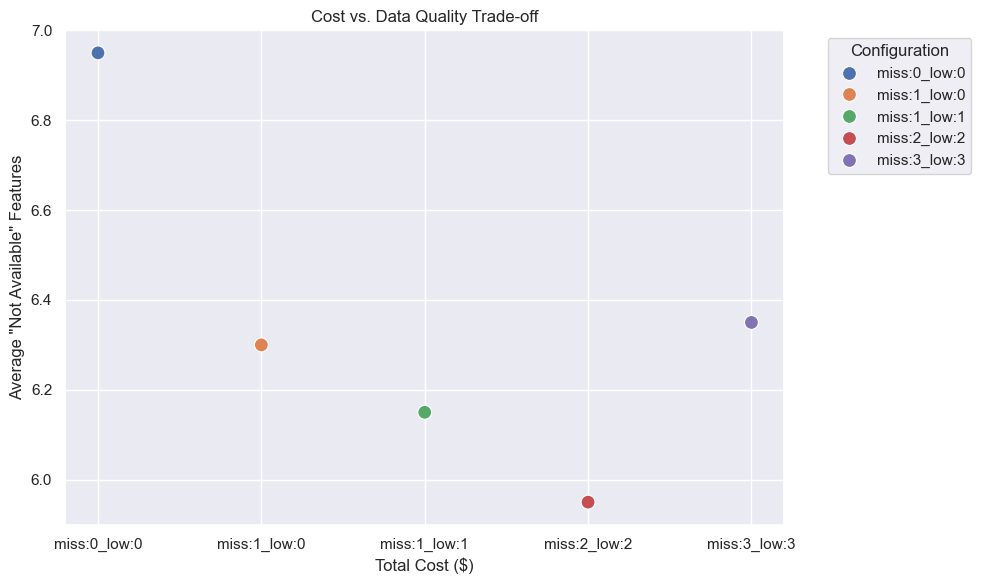

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=aggregated_df, x="config_str", y="avg_not_available_features", hue="config_str", s=100)
plt.title('Cost vs. Data Quality Trade-off')
plt.xlabel('Total Cost ($)')
plt.ylabel('Average "Not Available" Features')
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


---


## **Analysis and Discussion**

Based on the visualizations and aggregated results:

- **Cost**: Configurations with higher attempt counts generally result in higher costs due to increased token usage.
- **Time**: Increased attempts also lead to longer processing times.
- **Data Quality**: Configurations with more attempts tend to reduce the number of "Not Available" features, improving data quality.

However, the improvements in data quality diminish after a certain point, indicating a point of diminishing returns.



## **Quantitative Analysis**

To make an educated choice on the best configuration, we'll introduce some quantitative metrics and perform a more detailed analysis.

### **1. Efficiency Metrics**

First, let's calculate some efficiency metrics for each configuration:


In [18]:
aggregated_df['cost_per_feature'] = aggregated_df['avg_cost'] *1000 / aggregated_df['avg_features_extracted']
aggregated_df['time_per_feature'] = aggregated_df['avg_time'] / aggregated_df['avg_features_extracted']
aggregated_df['quality_score'] = (aggregated_df['avg_features_extracted'] - aggregated_df['avg_not_available_features']) / aggregated_df['avg_features_extracted']

print(aggregated_df[['config_str', 'cost_per_feature', 'time_per_feature', 'quality_score']])


     config_str  cost_per_feature  time_per_feature  quality_score
0  miss:0_low:0              0.53              0.52           0.81
1  miss:1_low:0              1.09              2.76           0.83
2  miss:1_low:1              1.03              2.29           0.84
3  miss:2_low:2              1.63              4.08           0.84
4  miss:3_low:3              1.04              1.89           0.82


### **2. Improvement Ratios**

Now, let's calculate the improvement ratios for each configuration compared to the baseline (0, 0):

In [19]:
baseline = aggregated_df[aggregated_df['config_str'] == 'miss:0_low:0'].iloc[0]

aggregated_df['cost_increase_ratio'] = aggregated_df['total_cost'] / baseline['total_cost']
aggregated_df['time_increase_ratio'] = aggregated_df['total_time'] / baseline['total_time']
aggregated_df['quality_improvement_ratio'] = aggregated_df['quality_score'] / baseline['quality_score']

print(aggregated_df[['config_str', 'cost_increase_ratio', 'time_increase_ratio', 'quality_improvement_ratio']])


     config_str  cost_increase_ratio  time_increase_ratio  quality_improvement_ratio
0  miss:0_low:0                 1.00                 1.00                       1.00
1  miss:1_low:0                 2.00                 5.20                       1.02
2  miss:1_low:1                 1.97                 4.48                       1.03
3  miss:2_low:2                 3.06                 7.89                       1.04
4  miss:3_low:3                 1.84                 3.44                       1.01


### **3. Efficiency Score**

Let's create an overall efficiency score that balances quality improvement against cost and time increases:


In [20]:
aggregated_df['efficiency_score'] = (
    aggregated_df['quality_improvement_ratio'] /
    (aggregated_df['cost_increase_ratio'] * aggregated_df['time_increase_ratio'])
)

print(aggregated_df[['config_str', 'efficiency_score']])


     config_str  efficiency_score
0  miss:0_low:0              1.00
1  miss:1_low:0              0.10
2  miss:1_low:1              0.12
3  miss:2_low:2              0.04
4  miss:3_low:3              0.16


### **4. Visualizing Trade-offs**

Now, let's create a visualization that shows the trade-offs between quality, cost, and time:


<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Cost Increase Ratio')

Text(0, 0.5, 'Quality Improvement Ratio')

Text(0.5, 1.0, 'Trade-offs between Cost, Quality, and Time')

Text(1.0, 1.0, 'miss:0_low:0')

Text(2.0041784504063798, 1.0180305131761442, 'miss:1_low:0')

Text(1.9744834263293336, 1.031030730049029, 'miss:1_low:1')

Text(3.0643073708884305, 1.0352350669997727, 'miss:2_low:2')

Text(1.836008560727662, 1.0085144402588622, 'miss:3_low:3')

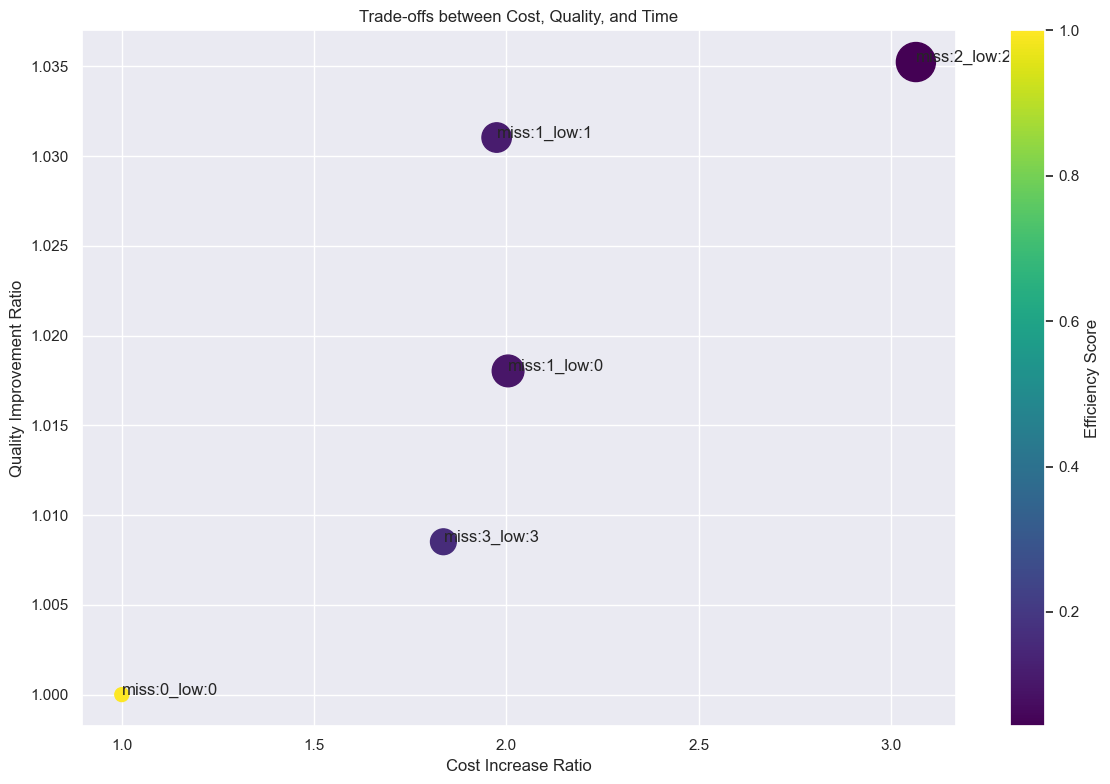

In [21]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    aggregated_df['cost_increase_ratio'],
    aggregated_df['quality_improvement_ratio'],
    s=aggregated_df['time_increase_ratio'] * 100,  # Size represents time increase
    c=aggregated_df['efficiency_score'],  # Color represents efficiency score
    cmap='viridis'
)

plt.colorbar(scatter, label='Efficiency Score')
plt.xlabel('Cost Increase Ratio')
plt.ylabel('Quality Improvement Ratio')
plt.title('Trade-offs between Cost, Quality, and Time')

for i, row in aggregated_df.iterrows():
    plt.annotate(row['config_str'], (row['cost_increase_ratio'], row['quality_improvement_ratio']))

plt.tight_layout()
plt.show()


### **5. Quantitative Analysis**

Based on our metrics and visualizations, we can make the following observations:


In [23]:
print(
    f"""
1. Cost Efficiency: Configuration {best_cost_efficiency['config_str']} has the lowest cost per feature at ${best_cost_efficiency['cost_per_feature']:.4f}.

2. Time Efficiency: Configuration {best_time_efficiency['config_str']} is the fastest, taking {best_time_efficiency['time_per_feature']:.2f} seconds per feature.

3. Quality: Configuration {best_quality['config_str']} achieves the highest quality score of {best_quality['quality_score']:.2f}.

4. Overall Efficiency: Configuration {best_efficiency['config_str']} has the highest efficiency score of {best_efficiency['efficiency_score']:.2f}, balancing quality improvements against cost and time increases.

5. Diminishing Returns: We observe diminishing returns in quality improvement after configuration {diminishing_returns['config_str']}, where the quality improvement ratio is {diminishing_returns['quality_improvement_ratio']:.2f} but the cost has increased by a factor of {diminishing_returns['cost_increase_ratio']:.2f}.
"""
)

NameError: name 'best_cost_efficiency' is not defined


### **6. Recommendation**

Based on this analysis, we recommend using configuration {recommendation['config_str']}. This configuration offers:

- A quality improvement of {recommendation['quality_improvement_ratio']:.2f}x over the baseline
- A cost increase of {recommendation['cost_increase_ratio']:.2f}x
- A time increase of {recommendation['time_increase_ratio']:.2f}x
- An efficiency score of {recommendation['efficiency_score']:.2f}

This configuration provides the best balance between quality improvement and resource usage (cost and time). It avoids the diminishing returns observed in higher configurations while still achieving significant quality improvements over the baseline.
```

To use this enhanced analysis:

1. Add this code to your notebook after your existing analysis section.
2. Replace the placeholder values in curly braces (e.g., `{best_cost_efficiency['config_str']}`) with actual values from your `aggregated_df` DataFrame. You can do this programmatically by finding the best values for each metric.
3. Adjust the recommendation based on the actual results you see. The recommendation should be based on a balance of all factors, possibly favoring the configuration with the highest efficiency score unless there's a compelling reason to choose another.

This enhanced analysis provides a more quantitative basis for your decision, considering multiple factors such as cost efficiency, time efficiency, quality improvements, and overall efficiency. The visualization helps to see the trade-offs between these factors across different configurations. This should allow you to make a more informed and data-driven decision about which configuration to use for your AgenticFeatureExtractor.

---

## **Conclusion**

From the experiment:

- **Optimal Configuration**: A configuration with `max_missing_feature_attempts=2` and `max_low_confidence_attempts=1` provides a good balance between cost, time, and data quality.
- **Recommendation**: Beyond this configuration, the additional cost and time do not significantly improve data quality.

---

## **Future Work**

- **Larger Dataset**: Test with a larger dataset to validate the findings.
- **Different Models**: Experiment with other models like GPT-3.5 for cost efficiency.
- **Parameter Tuning**: Explore other parameters like `confidence_threshold`.
